# Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# lazy 
from lazypredict.Supervised import LazyClassifier
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin

# search hyperparameters
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

import xgboost as xgb
import shap

# métriques 
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import classification_report,accuracy_score, f1_score, fbeta_score
from sklearn.metrics import make_scorer, confusion_matrix, precision_score, recall_score, precision_recall_curve

# Rééchantillonage
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from imblearn.under_sampling import RandomUnderSampler

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# sauvegarde model
import pickle

# import des fonctions de modélisations
import  modeling_functions as mf




# Chargement données issues du preprocessing

In [2]:

# jeu de données issues du preprocessing mixte
df_V1 = pd.read_csv("../data_saved/df_final.csv", index_col=["id_Location","id_Date"])

# jeu de données issues du preprocessing successif
df_V2 =  pd.read_csv("../data_saved/data_preprocessed_V2.csv", index_col=["id_Location","id_Date"])
df_V2 = df_V2.drop(columns=["Evaporation", 'Sunshine', 'Cloud9am', 'Cloud3pm'])

# jeu de données issues du preprocessing successif pour Canberra
df_Canberra =  pd.read_csv("../src/data_location_V2/df_Canberra.csv", index_col=["id_Location","id_Date"])

print(df_V1.shape)
print(df_V1.columns)
print(df_V2.shape)
print(df_V2.columns)
print(df_Canberra.shape)
print(df_Canberra.columns)

(135600, 42)
Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'WindGustDir_cos', 'WindGustDir_sin', 'WindDir9am_cos',
       'WindDir9am_sin', 'WindDir3pm_cos', 'WindDir3pm_sin', 'Month_cos',
       'Month_sin', 'Season_cos', 'Season_sin', 'Climate_Desert',
       'Climate_Grassland', 'Climate_Subtropical', 'Climate_Temperate',
       'Climate_Tropical', 'Year_2007', 'Year_2008', 'Year_2009', 'Year_2010',
       'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017'],
      dtype='object')
(142193, 94)
Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday',
       'RainTomorrow', 'sin_lat', 'cos_lat', 'sin_

In [16]:
print(df_V1.dropna().shape)
print(df_V2.dropna().shape)

(135600, 42)
(136222, 94)


In [17]:
# fonctions pour ajouter des lags aux variables

col_lagged = ["Rainfall","RainToday"]








# Séparation en train et test 

In [3]:
X_train_V2, X_test_V2, y_train_V2, y_test_V2 = mf.separation_train_test(df_V2, sep_method="classique")
X_train_V1, X_test_V1, y_train_V1, y_test_V1 = mf.separation_train_test(df_V1, sep_method="classique")

In [4]:
X_train_V2t, X_test_V2t, y_train_V2t, y_test_V2t = mf.separation_train_test(df_V2, sep_method="temporelle")
X_train_V1t, X_test_V1t, y_train_V1t, y_test_V1t = mf.separation_train_test(df_V1, sep_method="temporelle")

Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015
Part des données par années  Date
2007   0.00
2008   0.02
2009   0.13
2010   0.25
2011   0.35
2012   0.46
2013   0.57
2014   0.70
2015   0.82
2016   0.94
2017   1.00
Name: count, dtype: float64
Séparation des données avant et après  2015


In [20]:
print(X_train_V1t.shape)
print(X_test_V1t.shape)
print(X_train_V2t.shape)
print(X_test_V2t.shape)

(94452, 39)
(41148, 39)
(94809, 92)
(41413, 92)


# Scaling

In [5]:
X_train_V1t_scaled, X_test_V1t_scaled = mf.scaling(X_train_V1t, X_test_V1t, scaler = MinMaxScaler())
X_train_V2t_scaled, X_test_V2t_scaled = mf.scaling(X_train_V2t, X_test_V2t, scaler = MinMaxScaler())

<Figure size 1000x1000 with 0 Axes>

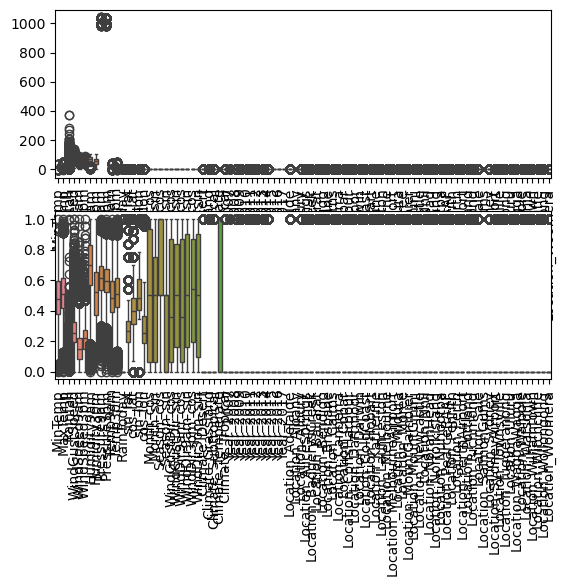

In [22]:
plt.figure(figsize = (10,10))
plt.subplots(ncols=1, nrows=2)
plt.subplot(211)
sns.boxplot(X_train_V2t)
plt.xticks(rotation=90)
plt.subplot(212)
sns.boxplot(X_train_V2t_scaled)
plt.xticks(rotation=90)
plt.show()

# Lazy predict 

In [23]:

removed_classifiers = [
"ClassifierChain",
"ComplementNB",
"GradientBoostingClassifier",
"GaussianProcessClassifier",
"HistGradientBoostingClassifier",
"MLPClassifier",
"LogisticRegressionCV",
"MultiOutputClassifier",
"MultinomialNB",
"OneVsOneClassifier",
"OneVsRestClassifier",
"OutputCodeClassifier",
"RadiusNeighborsClassifier",
"VotingClassifier",
'SVC','LabelPropagation','LabelSpreading','NuSV']


In [24]:

# models_V2t, predictions_V2t = mf.lazy_results(X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t)
# models_V1t, predictions_V1t = mf.lazy_results(X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t)

# models_V1t.to_csv("../modeling_results/lazy_predict_mixtepreprocessing_temp.csv",  decimal = ",")
# models_V2t.to_csv("../modeling_results/lazy_predict_succereprocessing_temp.csv",  decimal = ",")




# Fit modèles simples 

In [7]:
# Choix de 3 modèles 
models_select  = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(n_estimators = 500, max_samples = 0.5,
                                           max_features = 0.5, n_jobs=-1)
}


In [ ]:
# Test sur données preprocessed V1

report_V1t, cm_V1t, models_V1t = \
    mf.fit_models(
        models_select, 
        X_train_V1t_scaled, X_test_V1t_scaled, y_train_V1t, y_test_V1t, 
        save_model = True, save_models_dir="base_V1t_",
        save_results=True,save_results_dir="Base/base_V1t_")


Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.90      0.89 32167.00
1.0                0.63    0.61      0.62  8981.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.76    0.75      0.76 41148.00
weighted avg       0.83    0.84      0.83 41148.00
Matrice de confusion :
       0.00  1.00
0.00  28878  3289
1.00   3490  5491


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.95      0.91 32167.00
1.0                0.74    0.48      0.58  8981.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.81    0.72      0.75 41148.00
weighted avg       0.84    0.85      0.84 41148.00
Matrice de confusion :
       0.00  1.00
0.00  30683  1484
1.00   4659  4322


Nom du modè

In [30]:
# Test sur données preprocessed V2

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
               X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_model = True, save_models_dir="base_V2t_",
               save_results=True,save_results_dir="Base/base_V2t_")



Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.78    0.48      0.59  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.75 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  30960  1275
1.00   4780  4398


Nom du modè

# Rééchantillonage

In [8]:
# oversampling et fit sur données preprocessed V2

X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = SMOTE())
X_train_rs_V2t, X_test_V2t_scaled =  mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rs_V2t_",
                  save_results=True, save_results_dir="Resample/rs_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 73484, 1.0: 73484}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                1.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.61    0.50      0.18 41413.00
weighted avg       0.83    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00     5  32230
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.65    0.63      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weighted avg       0.84

In [9]:
# undersampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = RandomUnderSampler())
X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rsunder_V2t_",
                  save_results=True, save_results_dir="Resample/rsunder_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 21325, 1.0: 21325}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.74      0.83 32235.00
1.0                0.47    0.81      0.60  9178.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.70    0.78      0.71 41413.00
weighted avg       0.83    0.76      0.78 41413.00
Matrice de confusion :
       0.00  1.00
0.00  23925  8310
1.00   1749  7429


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84

In [10]:
# combinaison over et under sampling et fit sur données preprocessed V2
X_train_rs_V2t, y_train_rs_V2t = mf.resample(X_train_V2t,  y_train_V2t, resampler = SMOTETomek())
X_train_rs_V2t, X_test_V2t_scaled = mf.scaling(X_train_rs_V2t, X_test_V2t, scaler=MinMaxScaler)

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select, 
                  X_train_rs_V2t, X_test_V2t_scaled, y_train_rs_V2t, y_test_V2t,
                  save_model = True, save_models_dir="rssmotek_V2t_",
                  save_results=True, save_results_dir="Resample/rssmotek_V2t_")


Classes échantillon initial : {0.0: 73484, 1.0: 21325}
Classes échantillon rééchantillonné : {0.0: 73229, 1.0: 73229}
Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                1.00    0.00      0.00 32235.00
1.0                0.22    1.00      0.36  9178.00
accuracy           0.22    0.22      0.22     0.22
macro avg          0.61    0.50      0.18 41413.00
weighted avg       0.83    0.22      0.08 41413.00
Matrice de confusion :
      0.00   1.00
0.00    24  32211
1.00     0   9178


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.90    0.90      0.90 32235.00
1.0                0.65    0.63      0.64  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.77      0.77 41413.00
weighted avg       0.84

In [14]:
# test Balanced RandomForest et Bagging sur V2t

models_select_balanced = {
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5, n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select_balanced, 
                  X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                  save_model = True, save_models_dir="imb_V2t_",
                  save_results=True, save_results_dir="Resample/imb_V2t_")



Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : BalancedRandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.87 32235.00
1.0                0.55    0.76      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26442  5793
1.00   2169  7009


Nom du modèle : BalancedBaggingClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.85      0.88 32235.00
1.0                0.58    0.73      0.64  9178.00
accuracy           0.82    0.82      0.82     0.82
macro avg          0.75    0.79      0.76 41413.00
weighted avg       0.84    0.82      0.83 41413.00
Matrice de confusion :
       0.00  1.00
0.00  27327  4908
1.00   2523  6655


In [15]:
# avec class_weight 
df_V2.RainTomorrow.value_counts(normalize=True)

models_select_cw = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1, 
                                             class_weight = {0 : 3, 1 : 1 }),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1,  
                                                     class_weight = {0 : 3, 1 : 1 }),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1,
                                                                      class_weight = {0 : 3, 1 : 1 }),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)
}

report_V2t, cm_V2t, models_V2t = \
    mf.fit_models(models_select_cw , 
                  X_train_V2t_scaled, X_test_V2t_scaled, y_train_V2t, y_test_V2t,
                  save_model = True, save_models_dir="cw_V2t_",
                  save_results=True, save_results_dir="Resample/cw_V2t_")




Fitting  LogisticRegression
Fitting  RandomForestClassifier
Fitting  BalancedRandomForestClassifier
Fitting  BalancedBaggingClassifier


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.98      0.91 32235.00
1.0                0.82    0.38      0.52  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.83    0.68      0.71 41413.00
weighted avg       0.84    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31451   784
1.00   5674  3504


Nom du modèle : RandomForestClassifier
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.87    0.96      0.91 32235.00
1.0                0.76    0.49      0.60  9178.00
accuracy           0.85    0.85      0.85     0.85
macro avg          0.82    0.72      0.76 41413.00
weighted avg       0.85    0.85      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0

# Optimisation des hyperparamètres

In [60]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,5)
print(weights)

# Hyperparamètres à tester pour chaque modèle
param_grids1 = {
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10], 
                           'solver': ['liblinear', 'lbfgs'],
                           'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BalancedRandomForestClassifier': {'n_estimators': [50, 100, 200], 
                               'max_depth': [10, 20, 30],
                               'criterion':['gini', 'entropy', 'log_loss'],
                               'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'BaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.1, 0.5, 1]},
    'BalancedBaggingClassifier': {'n_estimators': [500, 1000, 2000], 
                           'max_samples' : [0.05, 0.1, 0.2, 0.5]}
}
# Hyperparamètres à tester pour chaque modèle (plus vaste)


param_grids2 = {
    'LogisticRegression': {
        'max_iter' : [100,500],
        'C':[0.001, 0.01, 0.1, 1, 10],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet', 'l1', 'l2'],
        'fit_intercept': [True, False],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 5, 10],
        'min_samples_split': [2, 5, 10,20],
        'class_weight': [{0 : 1 , 1 : 1 }, {0 : 3, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BalancedRandomForestClassifier': {
        'n_estimators': [100, 200, 1000],
        'criterion': ['gini', 'entropy', 'log_loss'], 
        'max_depth': [10, 30, 50],
        'max_features': ['sqrt', None],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'class_weight': [{0 : 1, 1 : 1 }, {0 : 3, 1 : 1 }, {0 : 4, 1 : 1 }]},
    'BaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]},
    'BalancedBaggingClassifier': {
        'n_estimators': [50, 500, 1000, 2000], 
        'max_samples' : [0.05, 0.1, 0.2, 0.5, 1],
        'max_features': [0.5, 0.8, 0.95, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False]}
}
param_grids3 = {
    'LogisticRegression': {
        'max_iter' : [100],
        'C':[0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['newton-cholesky','newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty':['none', 'elasticnet'],
        'fit_intercept': [True],
        'class_weight': [{0:x, 1:1.0-x} for x in weights]},
}



[0.     0.2475 0.495  0.7425 0.99  ]


In [7]:
models_select_search = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1),
    'BalancedRandomForestClassifier': BalancedRandomForestClassifier(n_jobs=-1),
    'BalancedBaggingClassifier': BalancedBaggingClassifier(n_estimators = 500, 
                                                           max_samples = 0.5, 
                                                           max_features = 0.5,
                                                           n_jobs=-1)
}


In [8]:
# tuning LR basique sans rééchantillonage 
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)

results_search_lr, search_lr = mf.optimize_parameters(
    model_name, model, 
    param_grids1[model_name],  
    X_train_V2t_scaled, X_test_V2t_scaled,
    y_train_V2t,  y_test_V2t,
    scoring="average_precision")


Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [16]:
# tuning LR plus large
model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)

results_search_lr2, search_lr2 = mf.optimize_parameters(
    model_name, model, 
    param_grids2[model_name],  
    X_train_V2t_scaled, X_test_V2t_scaled,
    y_train_V2t,  y_test_V2t,
    scoring='f1', 
    search_method='GridSearchCV')

Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01, 'class_weight': {0: 0.2475, 1: 0.7525}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.5989682690990245, 'test_accuracy': 0.7935913843479101, 'test_f1_score': 0.6033042509745684, 'test_precision': 0.5254648342764754, 'test_recall': 0.7082152974504249}}}
LogisticRegression(C=0.01, class_weight={0: 0.2475, 1: 0.7525}, max_iter=500,
                   n_jobs=-1, penalty='l1', solver='saga')
0.5989682690990245


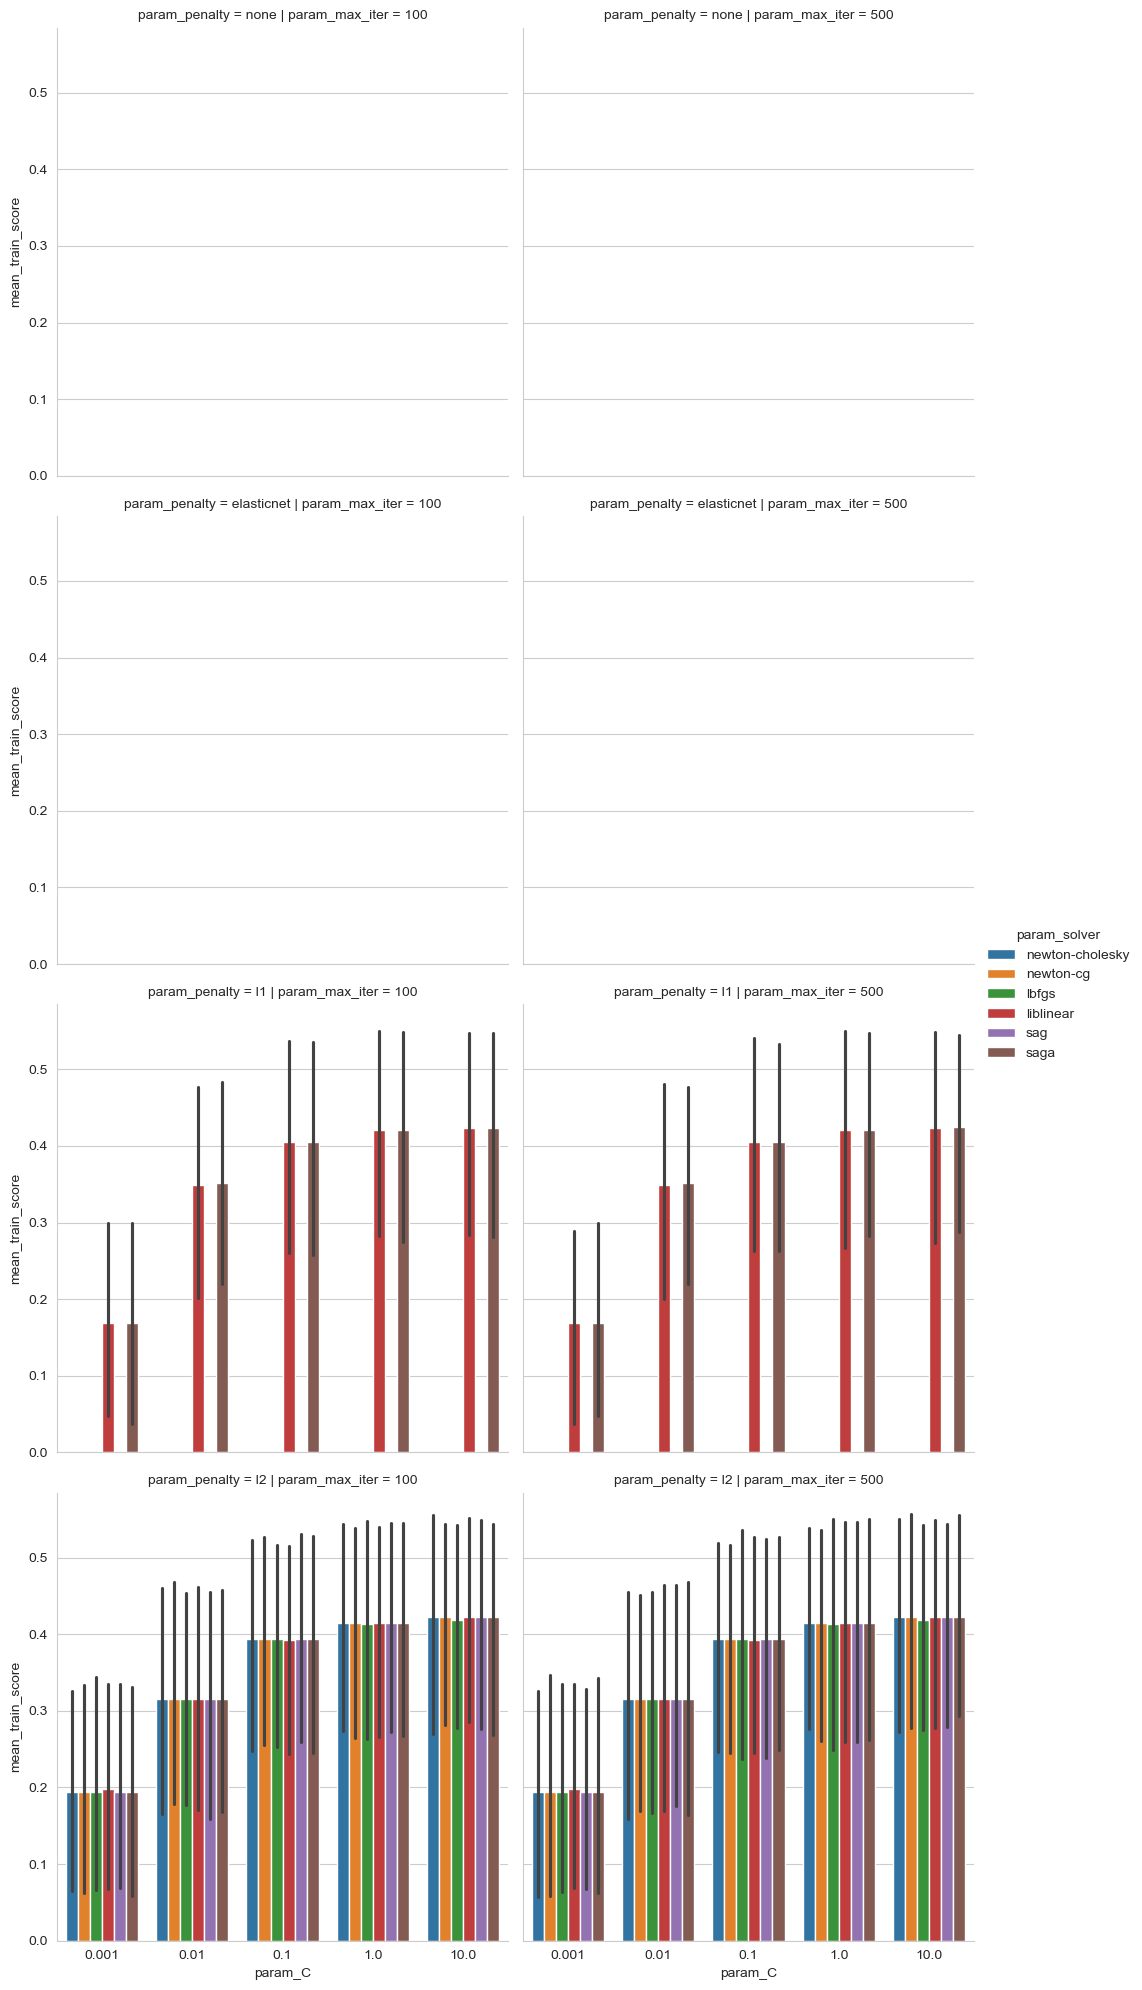

In [64]:
print(results_search_lr2)
print(search_lr2.best_estimator_)
print(search_lr2.best_score_)

table_results = pd.DataFrame(search_lr2.cv_results_)
sns.catplot(x = table_results["param_C"], y = table_results["mean_train_score"], 
            kind = "bar",
             hue = table_results["param_solver"], 
             row = table_results["param_penalty"],
             col = table_results["param_max_iter"])

In [112]:
# fit et sauvegarde (pickle, résultats) le meilleur modèle 
best_params_lr = results_search_lr2["LogisticRegression"]["GridSearchCV"]["best_params"]
lr_best = LogisticRegression(**results_search_lr2["LogisticRegression"]["GridSearchCV"]["best_params"],
                             n_jobs=-1)

models_select_best = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'LogisticRegression_weighted': LogisticRegression(max_iter = 500, n_jobs=-1, class_weight =  {0: 3, 1: 1}),
    'LogisticRegression_tuned': lr_best,
}

report, cm, models = \
    mf.fit_models(models_select_best, X_train_V2t_scaled, 
               X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_model = True, save_models_dir="/global/bestlargegrid_V2t_",
               save_results=True, save_results_dir="Best/bestlargegrid_V2t_")

Fitting  LogisticRegression
Fitting  LogisticRegression_weighted
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : LogisticRegression_weighted
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.98      0.91 32235.00
1.0                0.82    0.38      0.52  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.83    0.68      0.71 41413.00
weighted avg       0.84    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31451   784
1.00   5674  3

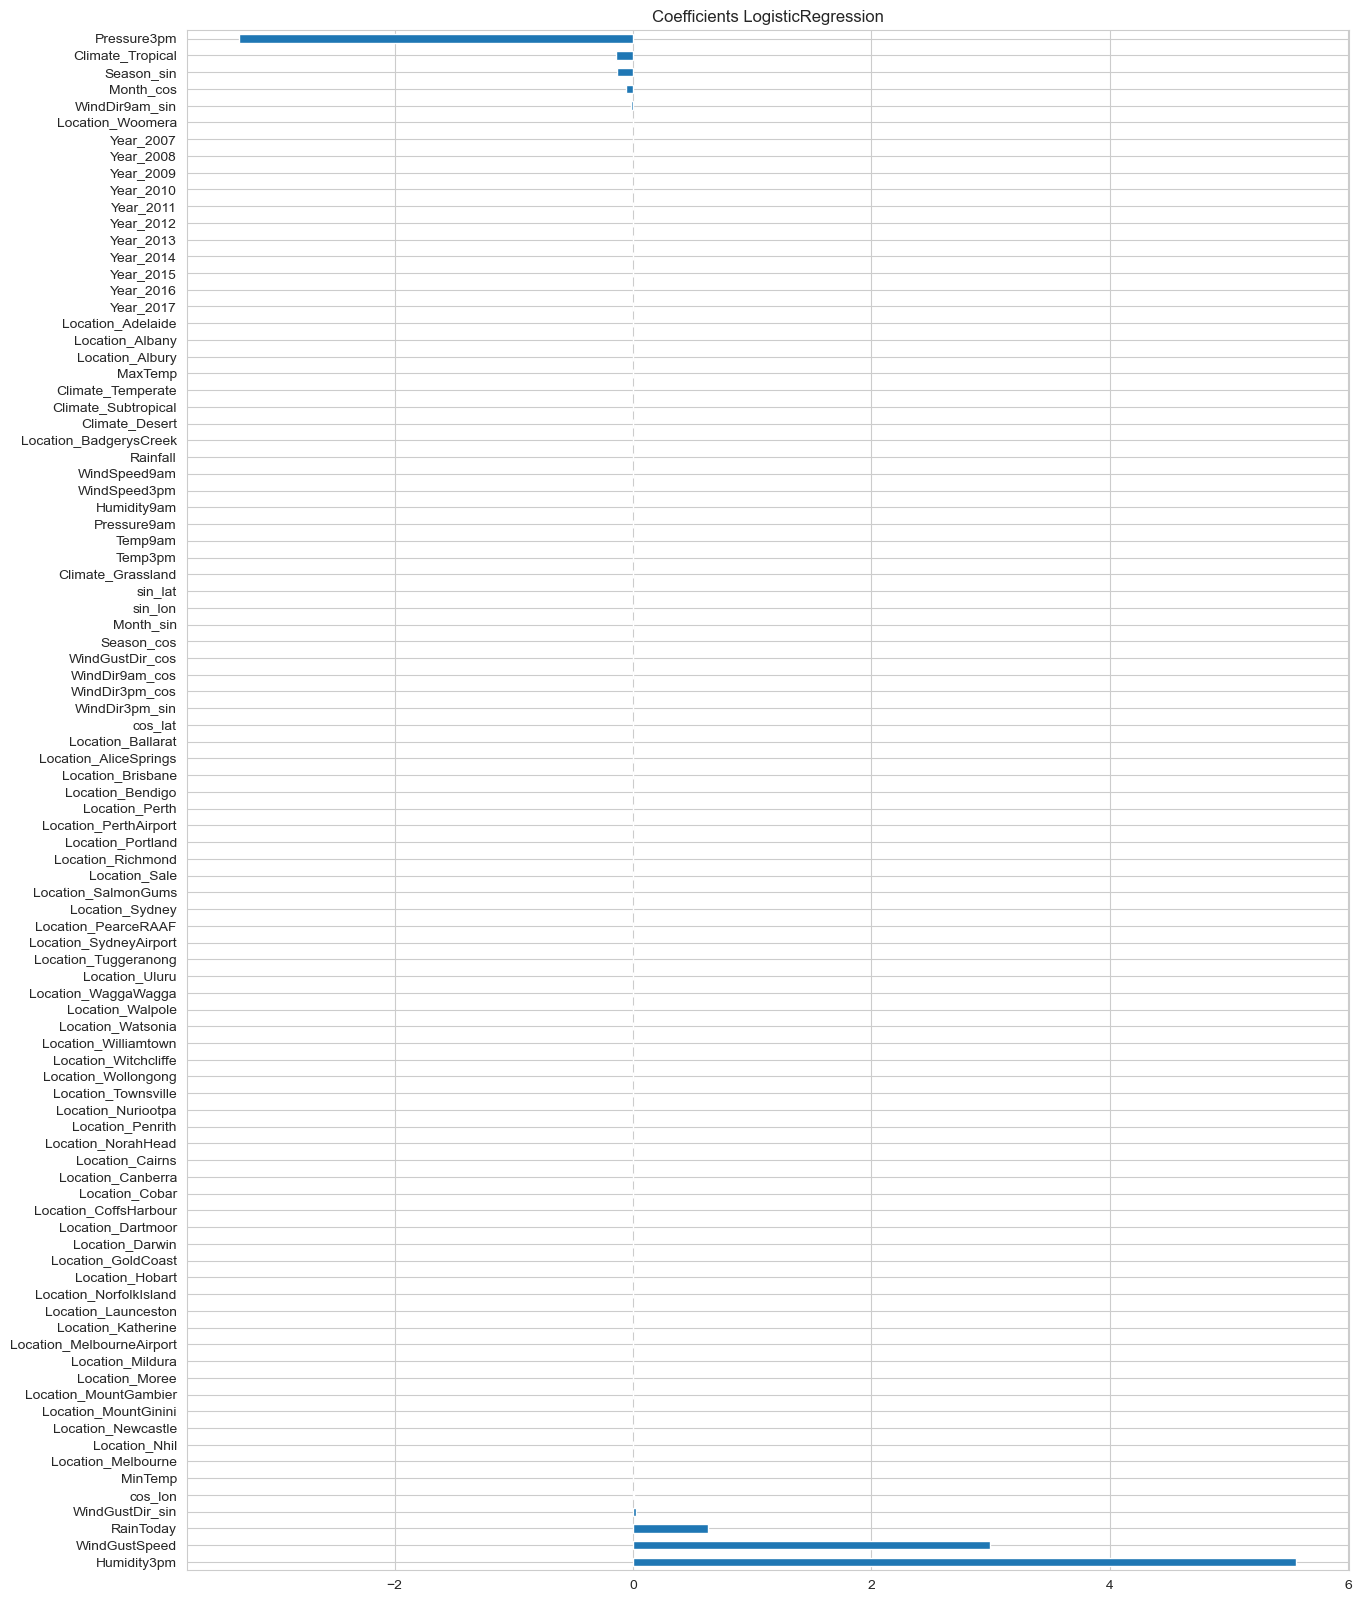

In [116]:
# Graph des coeff de la LogisticRegression (A VERIFIER)

model_name = "LogisticRegression" 
model_dir = "../saved_models/global/bestlargegrid_V2t_" + model_name + "_tuned"
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)


X_train_V2t_scaled.columns
pd.Series(model.coef_[0],
          X_train_V2t_scaled.columns).sort_values(ascending=False)\
                .plot(kind='barh', figsize=(15,20));
plt.title("Coefficients " + model_name)

graph_dir = "../modeling_results/Best/best_V2t_" + model_name + "_tuned"
plt.savefig(graph_dir + ".png")


In [63]:
# tuning LR plus large avec autre scorer
f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
scoring = {"f2_score" : f2_score, 
           "accuracy" : make_scorer(accuracy_score)}


model_name = 'LogisticRegression'
model = LogisticRegression(max_iter=500, n_jobs=-1)

results_search_lr3, search_lr3 = mf.optimize_parameters(
    model_name, model, 
    param_grids2[model_name],  
    X_train_V2t_scaled, X_test_V2t_scaled,
    y_train_V2t,  y_test_V2t,
    scoring=scoring, 
    search_method='GridSearchCV')

Optimizing LogisticRegression


GridSearchCV
Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


{'LogisticRegression': {'GridSearchCV': {'best_params': {'C': 0.01, 'class_weight': {0: 0.495, 1: 0.505}, 'fit_intercept': True, 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}, 'best_cv_score': 0.8336972228374943, 'test_accuracy': 0.8400260787675368, 'test_f1_score': 0.5483057203245381, 'test_precision': 0.7325560211331754, 'test_recall': 0.43811287862279363}}}
LogisticRegression(C=0.01, class_weight={0: 0.495, 1: 0.505}, max_iter=500,
                   n_jobs=-1, penalty='l1', solver='saga')
0.8336972228374943
      mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0              0.04          0.00             0.00            0.00     0.00   
1              0.04          0.00             0.00            0.00     0.00   
2              0.04          0.00             0.00            0.00     0.00   
3              0.04          0.00             0.00            0.00     0.00   
4              0.05          0.01             0.00            0.00     0.00   
...

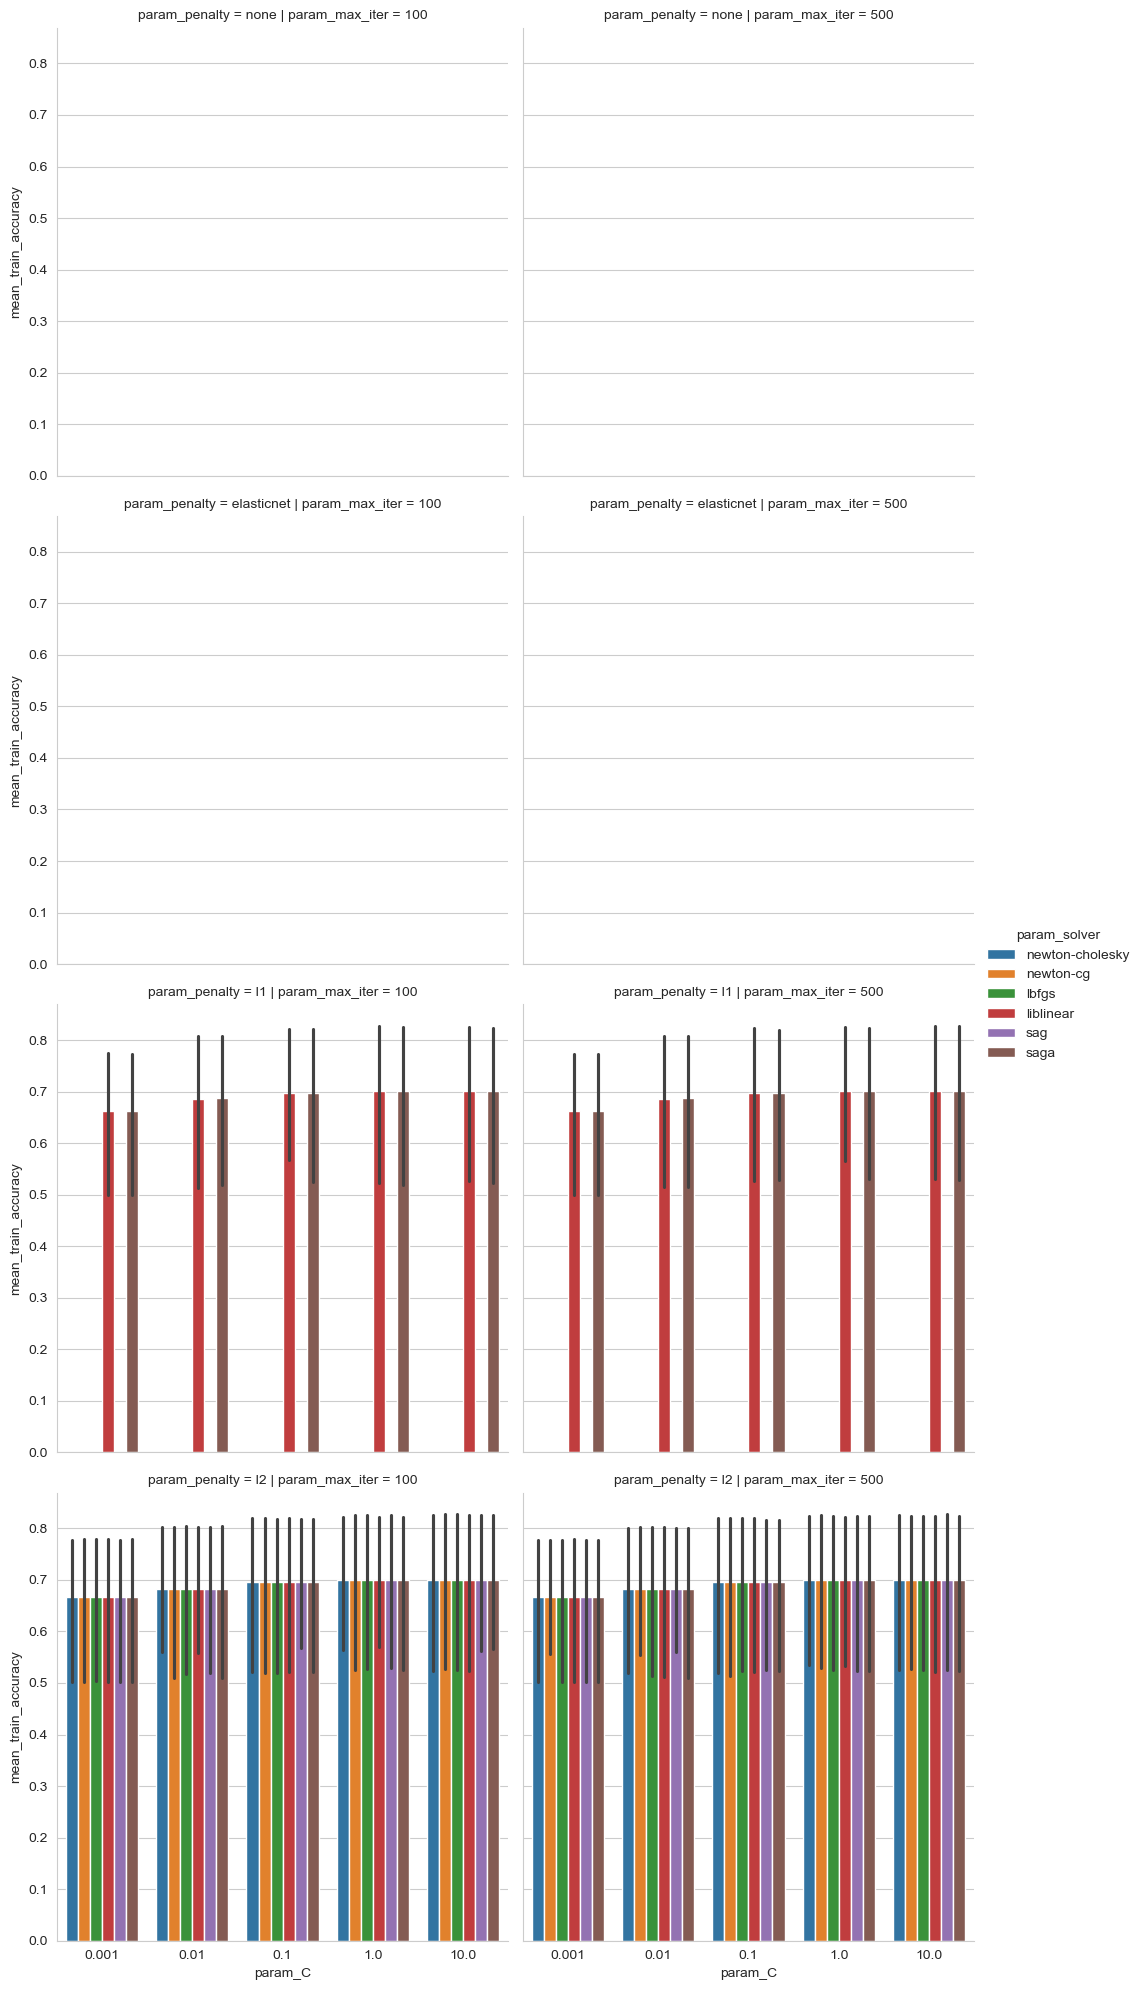

In [ ]:
print(results_search_lr3)
print(search_lr3.best_estimator_)
print(search_lr3.best_score_)

table_results = pd.DataFrame(search_lr3.cv_results_)
sns.catplot(x = table_results["param_C"], 
            y = table_results["mean_train_accuracy"], 
            kind = "bar",
             hue = table_results["param_solver"], 
             row = table_results["param_penalty"],
             col = table_results["param_max_iter"])

In [117]:
# fit et sauvegarde (pickle, résultats) le meilleur modèle 
best_params_lr = results_search_lr3["LogisticRegression"]["GridSearchCV"]["best_params"]
lr_best = LogisticRegression(**results_search_lr3["LogisticRegression"]["GridSearchCV"]["best_params"],
                             n_jobs=-1)

models_select_best = {
    'LogisticRegression': LogisticRegression(max_iter = 500, n_jobs=-1),
    'LogisticRegression_weighted': LogisticRegression(max_iter = 500, n_jobs=-1, class_weight =  {0: 3, 1: 1}),
    'LogisticRegression_tuned': lr_best,
}

report, cm, models = \
    mf.fit_models(models_select_best, X_train_V2t_scaled, 
               X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_model = True, save_models_dir="/global/bestlargegrid_f2score_V2t_",
               save_results=True, save_results_dir="Best/bestlargegrid_f2score_V2t_")

Fitting  LogisticRegression
Fitting  LogisticRegression_weighted
Fitting  LogisticRegression_tuned


Nom du modèle : LogisticRegression
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.89    0.91      0.90 32235.00
1.0                0.66    0.59      0.62  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.77    0.75      0.76 41413.00
weighted avg       0.84    0.84      0.84 41413.00
Matrice de confusion :
       0.00  1.00
0.00  29489  2746
1.00   3772  5406


Nom du modèle : LogisticRegression_weighted
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.85    0.98      0.91 32235.00
1.0                0.82    0.38      0.52  9178.00
accuracy           0.84    0.84      0.84     0.84
macro avg          0.83    0.68      0.71 41413.00
weighted avg       0.84    0.84      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  31451   784
1.00   5674  3

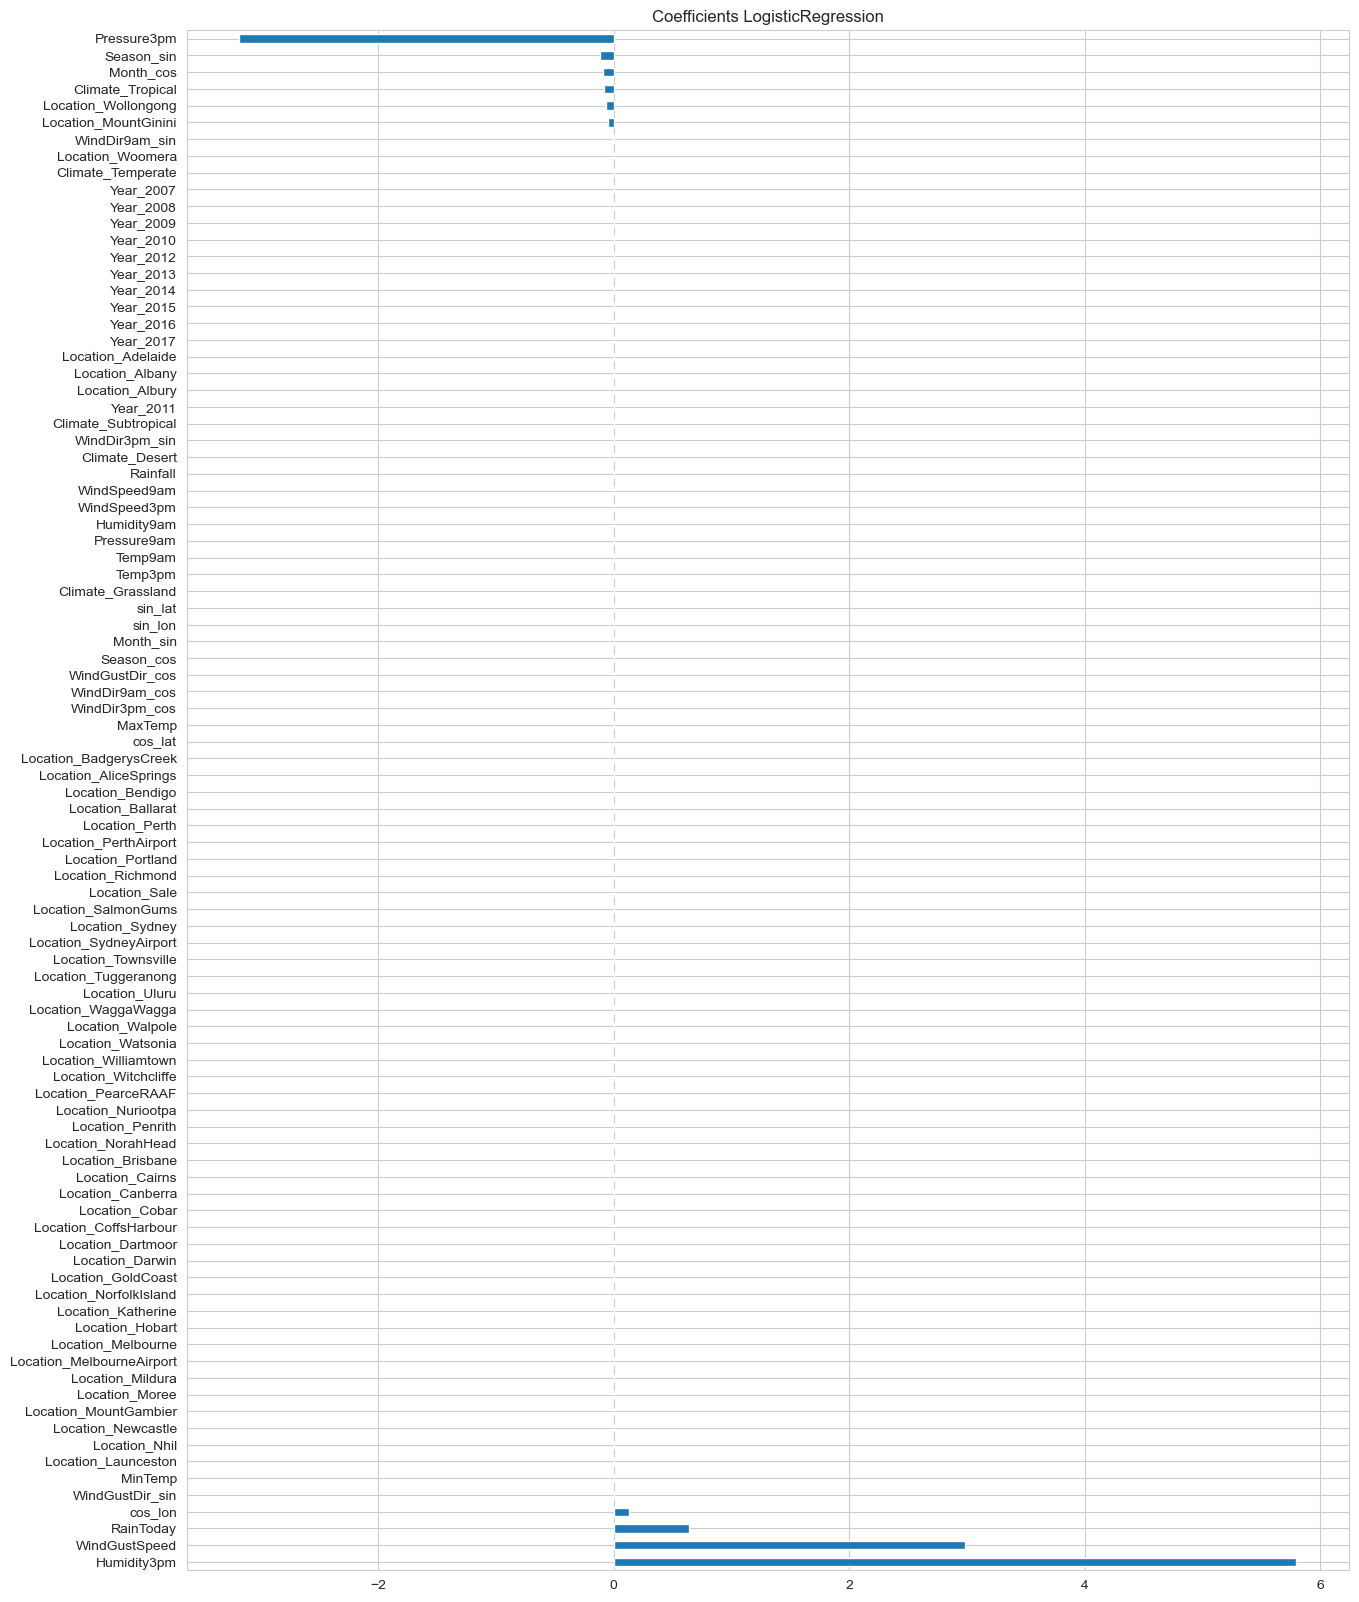

In [119]:
model_name = "LogisticRegression" 
model_dir = "../saved_models/global/bestlargegrid_f2score_V2t_" + model_name + "_tuned"
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)

pd.Series(model.coef_[0],
          X_train_V2t_scaled.columns).sort_values(ascending=False)\
                .plot(kind='barh', figsize=(15,20));
plt.title("Coefficients " + model_name)

graph_dir = "../modeling_results/Best/best_V2t_" + model_name + "_tuned"
plt.savefig(graph_dir + ".png")

'LogisticRegression'

In [ ]:
# tuning BalancedRandomForest 
model_name = 'BalancedRandomForestClassifier'
model = BalancedRandomForestClassifier(n_jobs=-1)
f2_score = make_scorer(fbeta_score, beta=0.5, pos_label=1)
scoring = {"f2_score" : f2_score, 
           "accuracy" : make_scorer(accuracy_score)}

results_search_brf, search_brf = mf.optimize_parameters(model_name, model, 
                       param_grids1[model_name],  
                       X_train_V2t_scaled, X_test_V2t_scaled,
                       y_train_V2t,  y_test_V2t,
                       scoring=scoring)

KeyError: 1

In [138]:
# fit et sauvegarde (pickle, résultats) le meilleur modèle
model_name = 'BalancedRandomForestClassifier' 
best_params_brf  = results_search_brf[model_name]["GridSearchCV"]["best_params"]
print(best_params_brf )
brf_best = BalancedRandomForestClassifier(**results_search_brf[model_name]["GridSearchCV"]["best_params"],
                             n_jobs=-1)


models_select_best = {
    'brf_tuned' : brf_best,
    'brf': BalancedRandomForestClassifier(n_jobs=-1),
    'rf' : RandomForestClassifier(n_jobs=-1)
}

report, cm, models = \
    mf.fit_models(models_select_best, X_train_V2t_scaled, 
               X_test_V2t_scaled, y_train_V2t, y_test_V2t,
               save_models_dir = "../saved_models/global/best_V2t_") 


{'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 200}
Fitting  brf_tuned
Fitting  brf
Fitting  rf


Nom du modèle : brf_tuned
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.92    0.82      0.86 32235.00
1.0                0.54    0.75      0.62  9178.00
accuracy           0.80    0.80      0.80     0.80
macro avg          0.73    0.78      0.74 41413.00
weighted avg       0.83    0.80      0.81 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26332  5903
1.00   2333  6845


Nom du modèle : brf
Rapport de classification :
              precision  recall  f1-score  support
0.0                0.93    0.82      0.87 32235.00
1.0                0.55    0.77      0.64  9178.00
accuracy           0.81    0.81      0.81     0.81
macro avg          0.74    0.79      0.75 41413.00
weighted avg       0.84    0.81      0.82 41413.00
Matrice de confusion :
       0.00  1.00
0.00  26431  5804
1.00   2143  7035


Nom du modèle : rf

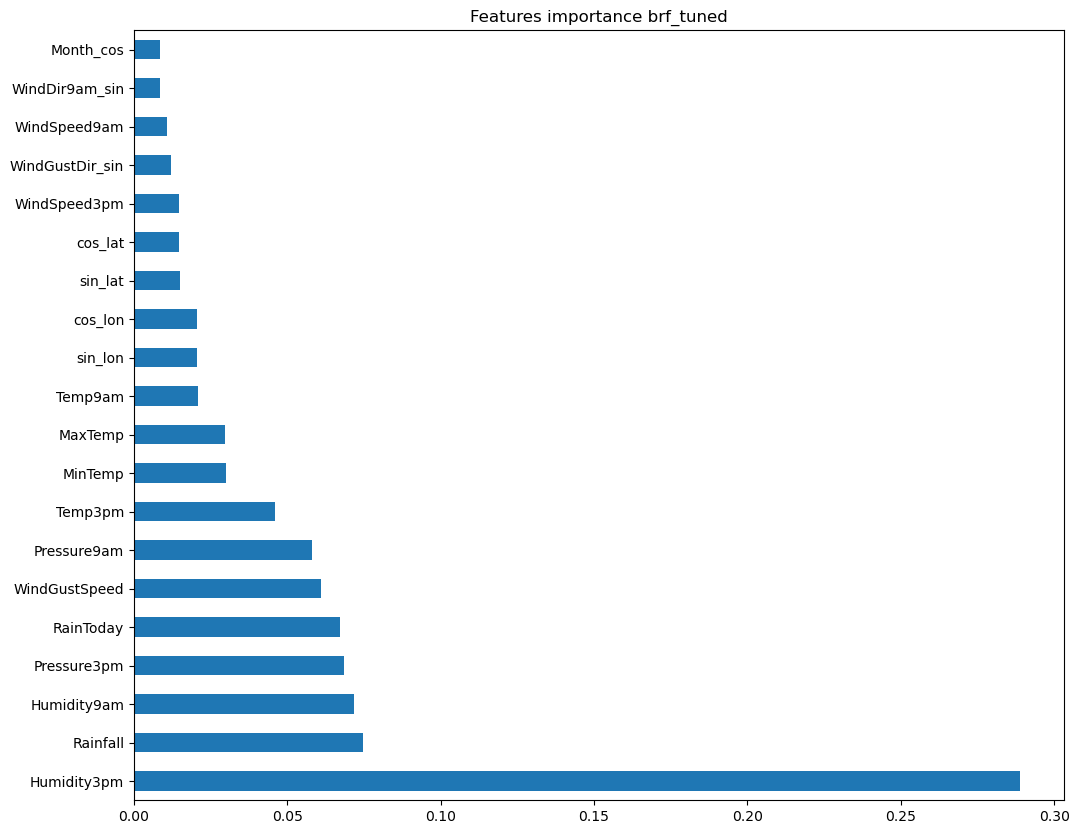

In [141]:
# Graph des Features importances pour le RandomForest

model_name = "brf_tuned" 
model_dir = "../saved_models/global/best_V2t_" + model_name
with open(model_dir + '.pkl', 'rb') as f:
    model = pickle.load(f)

# features importances 
feat_importances = pd.Series(
    model.feature_importances_, index=X_train_V2t_scaled.columns)
fig = plt.figure(figsize = (12,10))
feat_importances.nlargest(20).plot(kind='barh');
plt.title("Features importance " + model_name)

graph_dir = "../modeling_results/best_V2t_" +  model_name
fig.savefig(graph_dir + ".png")